# Testing the PET-CT pipeline implemented in the custom dataset class and data loader 

In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torchio
from torchio.transforms import HistogramStandardization

import sys
sys.path.append('../')
from dataset_classes.HECKTORPETCTDataset import HECKTORPETCTDataset
from data_utils.preprocessing import Preprocessor
from data_utils.visualization import NdimageVisualizer, display_image
from data_utils.conversion import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFH_rs113_hecktor_nii"
patient_id_filepath = "../hecktor_meta/patient_IDs_train.txt"

preprocessor = Preprocessor()
viz = NdimageVisualizer()

sample_idx = 0

## Separate volume representation

In [3]:
PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='train', 
                                     input_representation='separate volumes', 
                                     augment_data=False)
PET_CT_dataset.set_preprocessor(preprocessor)

sample_dict = PET_CT_dataset[sample_idx]
print(sample_dict['PET'].shape)
print(sample_dict['PET'].min())
print(sample_dict['PET'].max())

# For visualization purpose
PET_np = sample_dict['PET'].squeeze().permute(2,1,0)
CT_np = sample_dict['CT'].squeeze().permute(2,1,0)
GTV_labelmap_np = sample_dict['GTV labelmap'].squeeze().permute(2,1,0)

torch.Size([1, 1, 100, 450, 450])
tensor(0.)
tensor(20.)


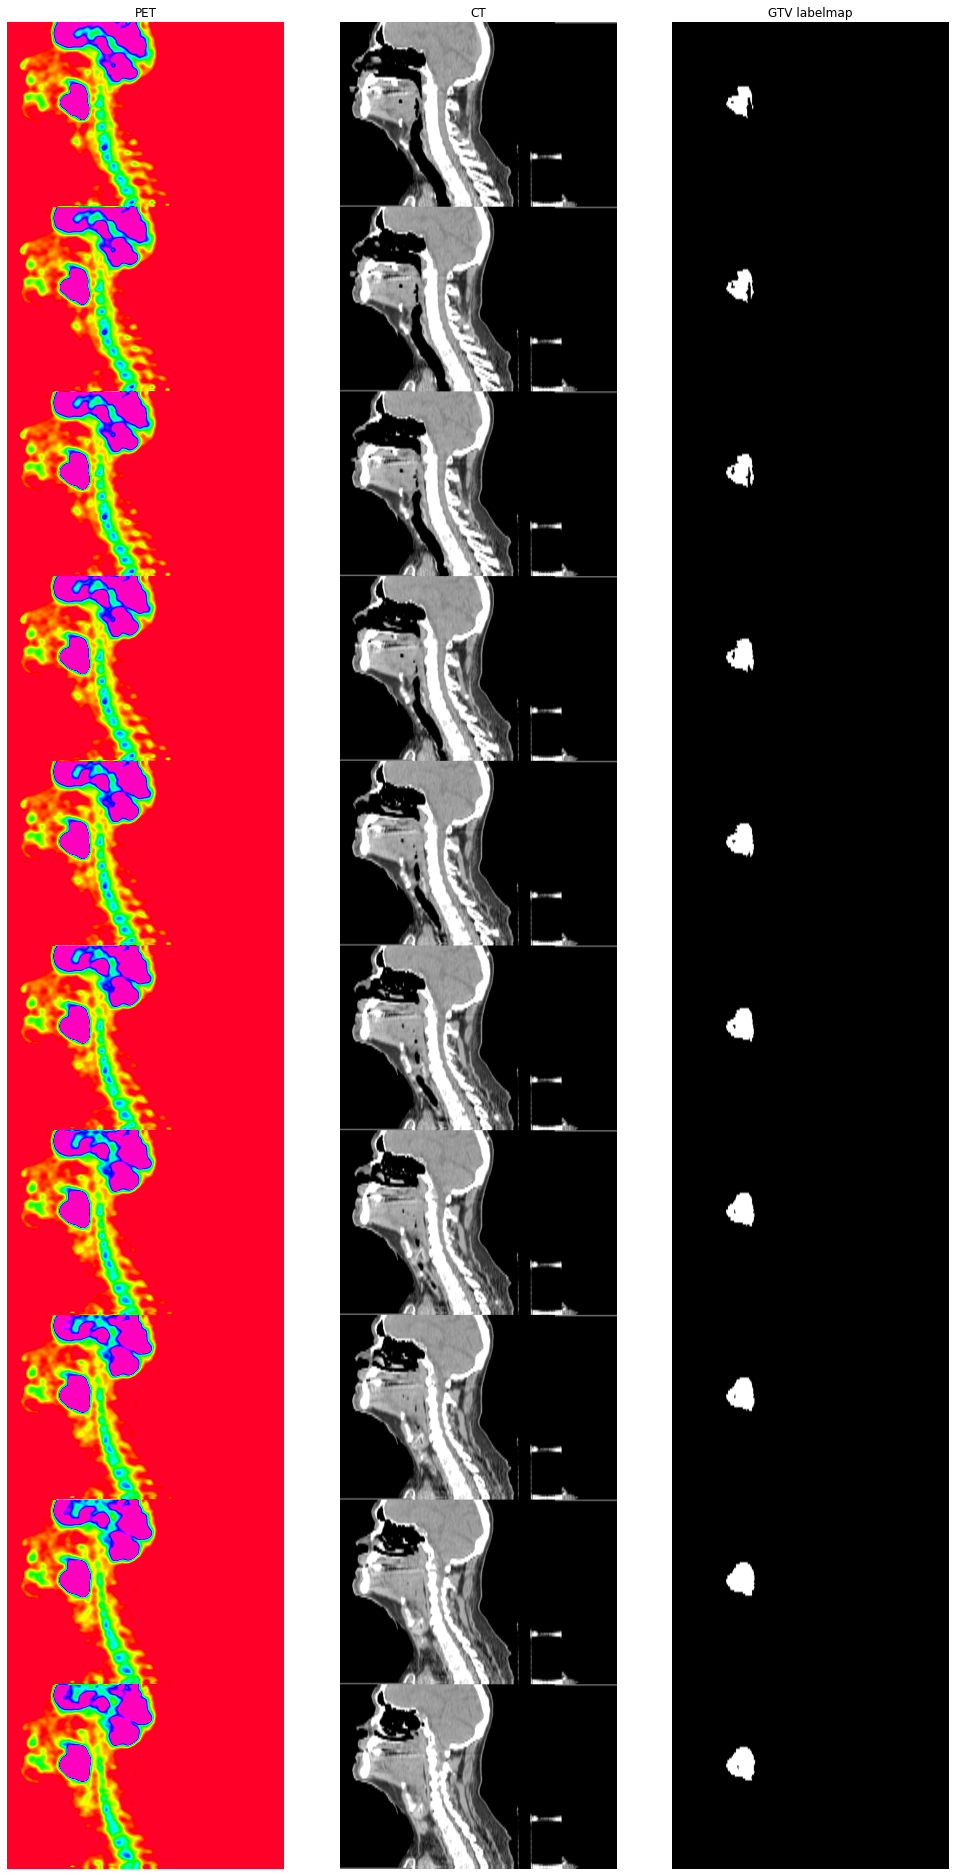

In [4]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV labelmap'],
                          idx_range=[230, 240],
                          view='sagittal',
                          subtitles=[])

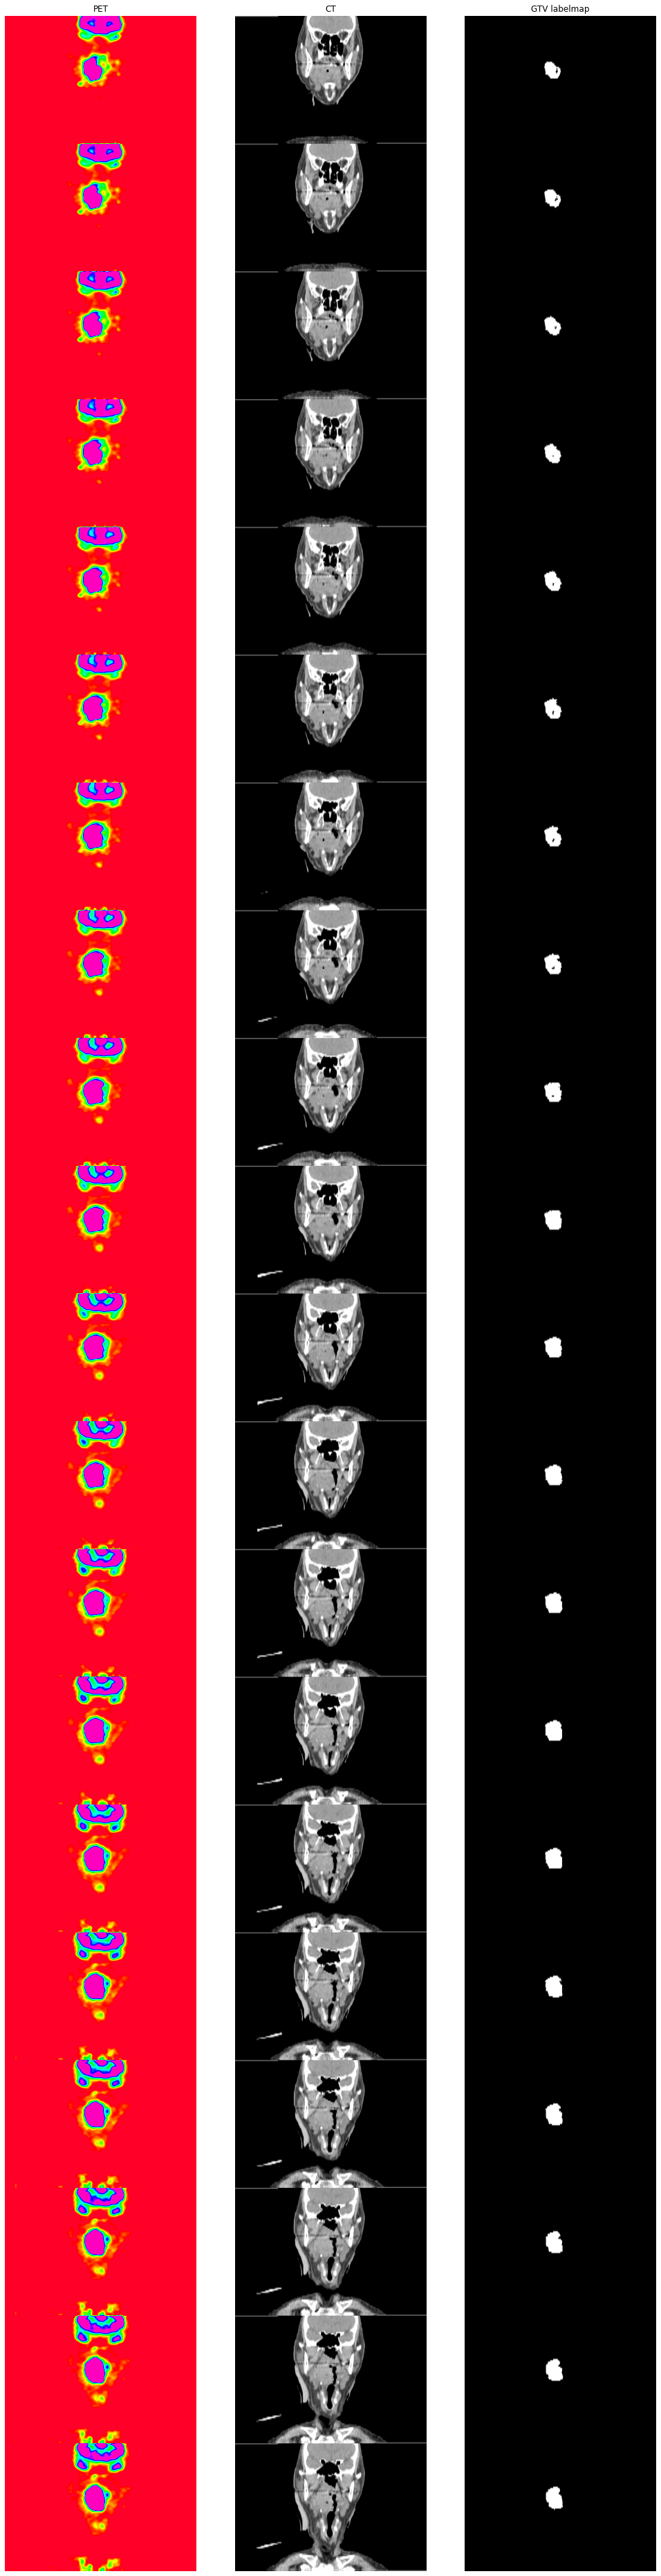

In [5]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV labelmap'],
                          idx_range=[100, 120],
                          view='coronal',
                          subtitles=[])

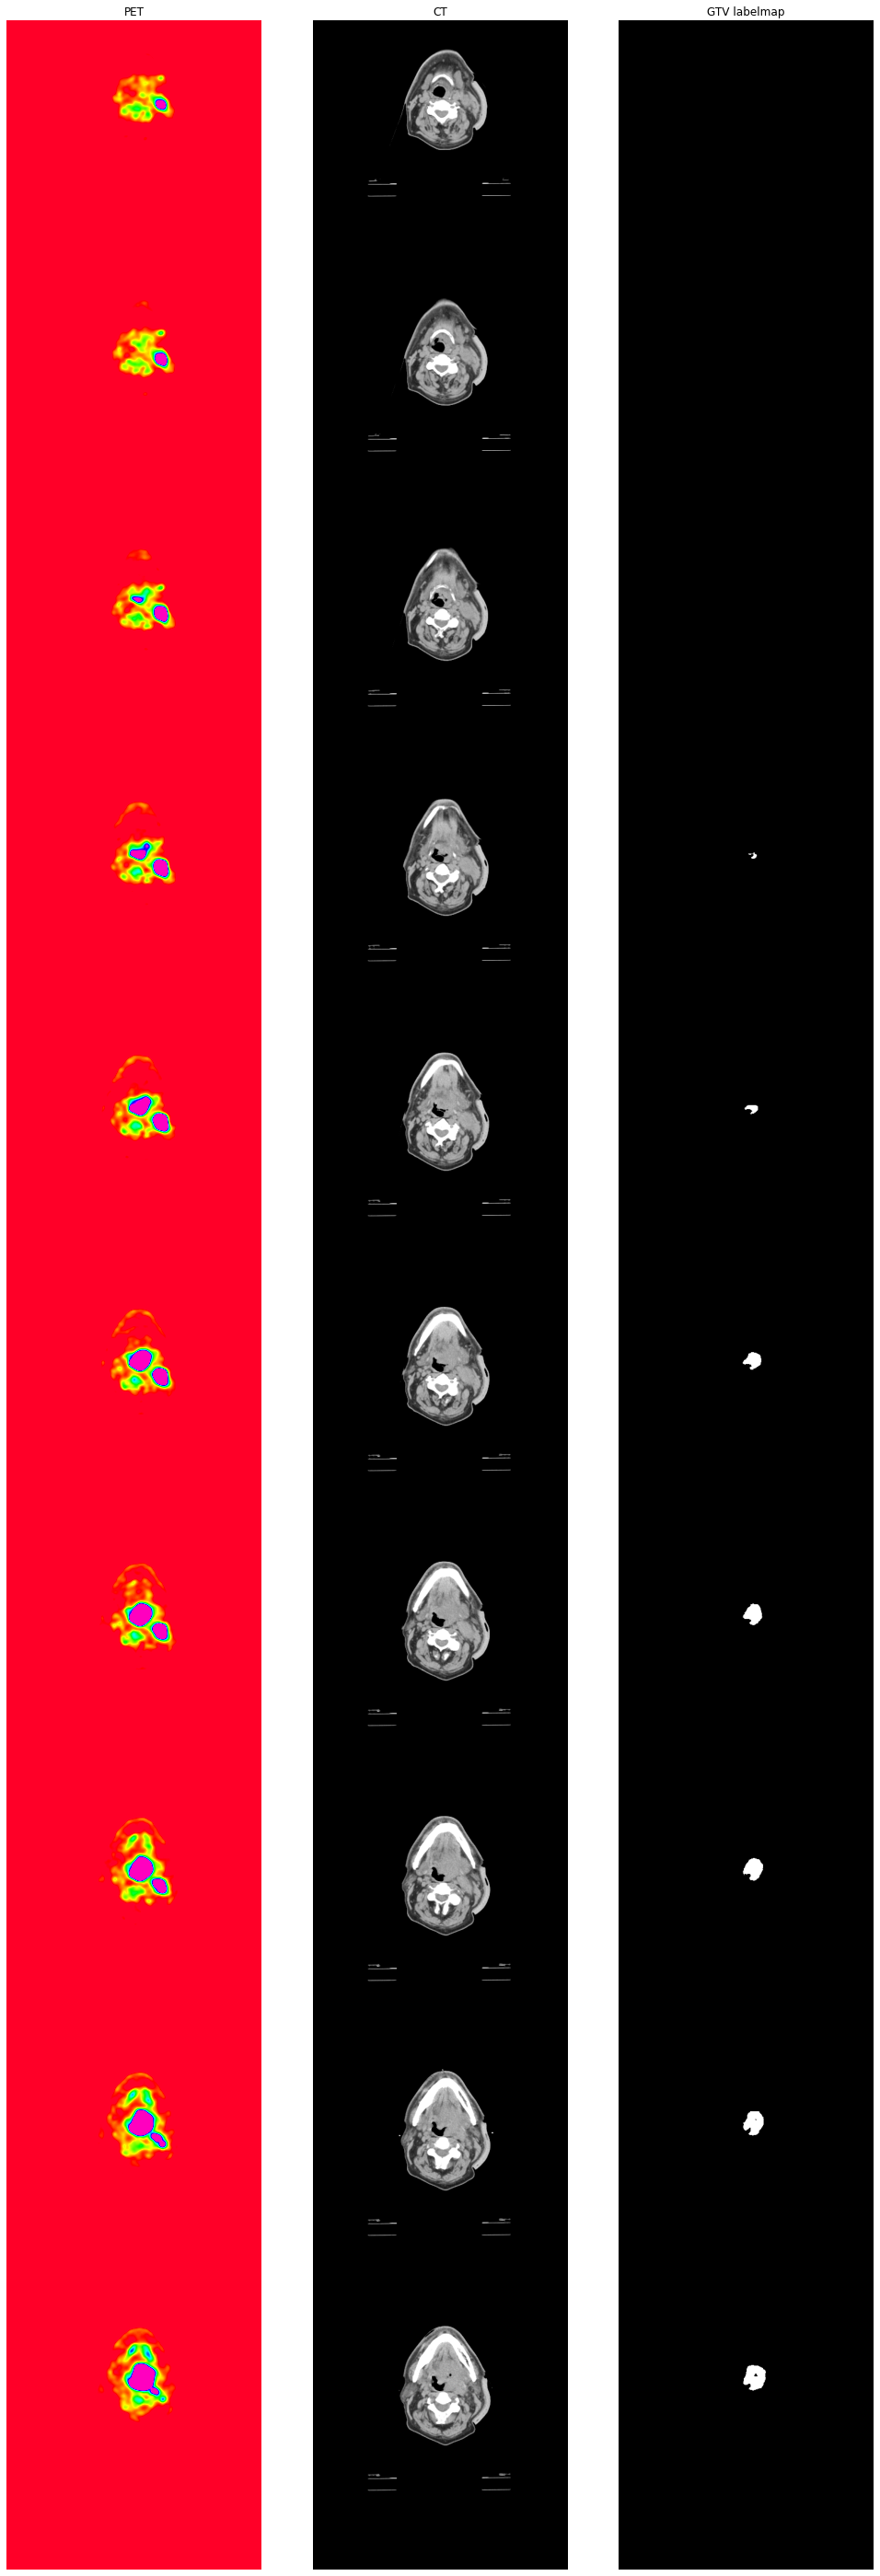

In [6]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV labelmap'],
                          idx_range=[45, 55],
                          view='axial',
                          subtitles=[])

In [7]:
t1 = torch.zeros(100,100,50)
t2 = torch.ones(100,100,50)

t3 = torch.stack([t1,t2], dim=0)
print(t3.shape)
print(t3[:,0,0,0])

torch.Size([2, 100, 100, 50])
tensor([0., 1.])


## Multichannel representation

In [8]:
PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='train', 
                                     input_representation='multichannel volume', 
                                     augment_data=True)
PET_CT_dataset.set_preprocessor(preprocessor)

sample_dict = PET_CT_dataset[sample_idx]
print(sample_dict['PET-CT'].shape)

# Extract into separate arrays for visualization
PET_np = sample_dict['PET-CT'].squeeze()[0,:,:,:].permute(2,1,0)
CT_np = sample_dict['PET-CT'].squeeze()[1,:,:,:].permute(2,1,0)
GTV_labelmap_np = sample_dict['GTV labelmap'].squeeze().permute(2,1,0)

stretching PET contrast
torch.Size([1, 2, 100, 450, 450])


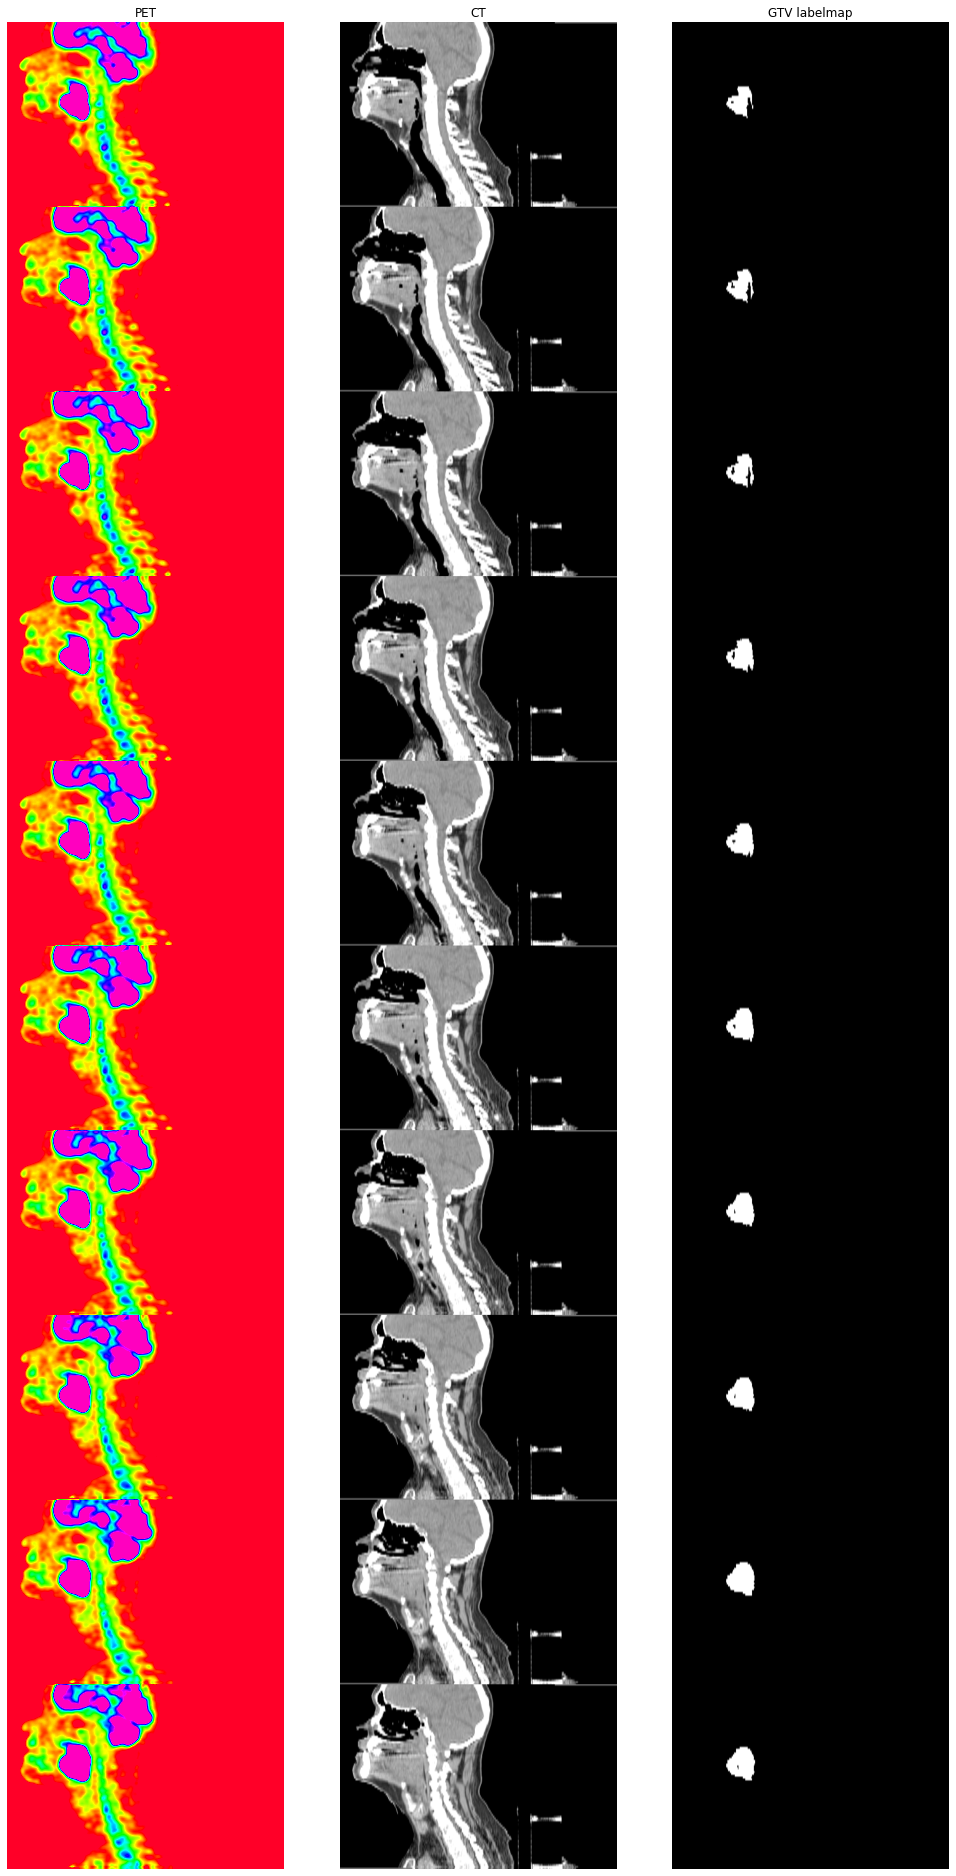

In [9]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV labelmap'],
                          idx_range=[230, 240],
                          view='sagittal',
                          subtitles=[])